# Introduction: Phase Kickback

In [1]:
import qiskit
from qiskit import *
import numpy as np

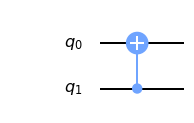

In [2]:
U_backend=Aer.get_backend(name="unitary_simulator")
qc1=QuantumCircuit(2)
qc1.cx(1,0)
qc1.draw(output="mpl")

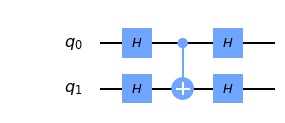

In [3]:
qc2=QuantumCircuit(2)
qc2.h([0,1])
qc2.cx(0,1)
qc2.h([0,1])
qc2.draw(output="mpl")

In [4]:
U1=execute(qc1,backend=U_backend).result().get_unitary()
U2=execute(qc2,backend=U_backend).result().get_unitary()

In [5]:
U1-U2<0.000001

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

### This identity is an example of kickback which is very important and is used in almost every quantum algorithm. 

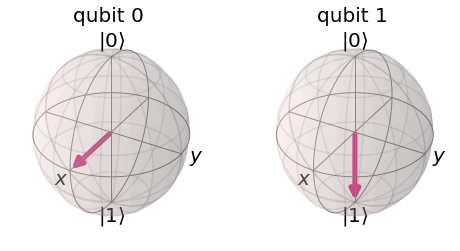

In [6]:
from qiskit.visualization import plot_bloch_multivector as pbs
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
#qc.h(1)
qc.draw()
final_state = execute(qc,backend=Aer.get_backend("statevector_simulator")).result().get_statevector()
pbs(final_state)

In [7]:
from math import pi

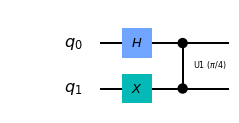

In [8]:
# If we apply the T-gate to a qubit in the state  |1⟩ , we add a phase of  e^iπ/4  to this qubit

qc.cu1(pi/4, 0, 1)
qc.draw(output="mpl")

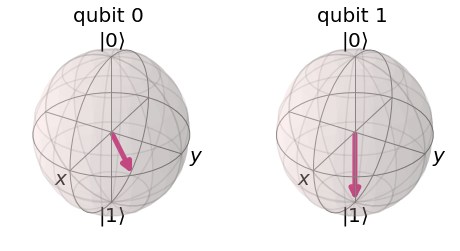

In [9]:
final_state = execute(qc,backend=Aer.get_backend("statevector_simulator")).result().get_statevector()
pbs(final_state)

#### 1. What would be the resulting state of the control qubit (q0) above if the target qubit was in the state  |0⟩ ? 

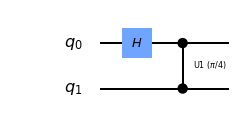

In [10]:
ex1=QuantumCircuit(2)
ex1.h(0)
ex1.cu1(pi/4, 0, 1)
ex1.draw(output="mpl")

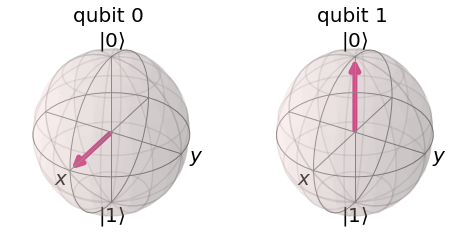

In [11]:
final_state = execute(ex1,backend=Aer.get_backend("statevector_simulator")).result().get_statevector()
pbs(final_state)

####  2. What would happen to the control qubit (q0) above if the circuit used a controlled-Sdg gate instead of the controlled-T?

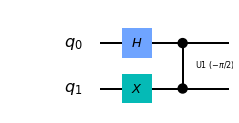

In [12]:
ex2=QuantumCircuit(2)
ex2.h(0)
ex2.x(1)
ex2.cu1(-pi/2,0,1)
ex2.draw("mpl")

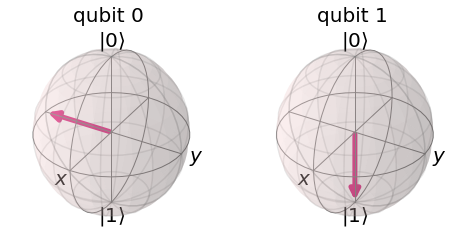

In [13]:
final_state = execute(ex2,backend=Aer.get_backend("statevector_simulator")).result().get_statevector()
pbs(final_state)

#### 3. What would happen to the control qubit above (q0) if it was in the state  |1⟩  instead of the state  |+⟩  before application of the controlled-T?

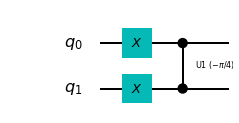

In [14]:
ex3=QuantumCircuit(2)
ex3.x(0)
ex3.x(1)
ex3.cu1(-pi/4,0,1)
ex3.draw("mpl")

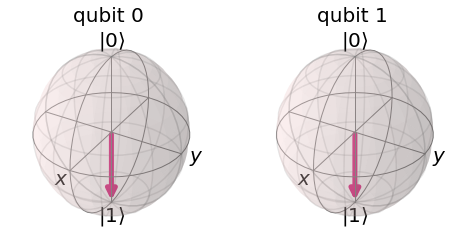

In [15]:
final_state = execute(ex3,backend=Aer.get_backend("statevector_simulator")).result().get_statevector()
pbs(final_state)

#  Deutsch-Josza algorithm 

In [20]:
def create_dj(case,n):
    dj_circuit=QuantumCircuit(n+1,n)
    
    #Set up the output Qubit
    dj_circuit.x(n)
    dj_circuit.h(n)
    #Set up the other Qubits
    for i in range(n):
        dj_circuit.h(i)
    
    dj_circuit.barrier()
    
    oracle=QuantumCircuit(n+1)
    if case=="balanced":
        b = np.random.randint(1,2**n)
        b_str = format(b, '0'+str(n)+'b')
        #X gates before
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle.x(qubit)
        #CX gates
        for qubit in range(n):
            oracle.cx(qubit, n)
        #X gates after
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle.x(qubit)
                
                
    if case == "constant":
        output = np.random.randint(2)
        if output == 1:
            oracle.x(n)
            
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    
    dj_circuit.barrier()
    
    for i in range(n):
        dj_circuit.h(i)
        dj_circuit.measure(i,i)
    
    dj_circuit.draw(output="mpl")
    
    return dj_circuit
            

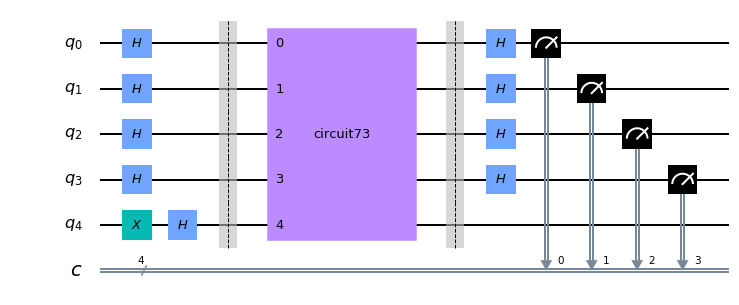

In [21]:
bal_qc=create_dj("balanced",4)
bal_qc.draw(output="mpl")

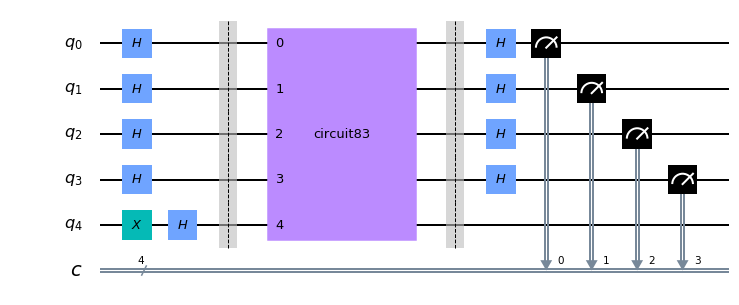

In [45]:
cons_qc=create_dj("constant",4)
cons_qc.draw(output="mpl")

In [40]:
from qiskit.providers.ibmq import least_busy
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (5) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)


ibmqfactory.load_account:WARNING:2020-05-08 18:03:00,066: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_burlington


In [41]:
from qiskit.tools.monitor import job_monitor
bal_job=execute(bal_qc,backend,shots=1024)

In [42]:
job_monitor(bal_job)

Job Status: job has successfully run


In [47]:
cons_job=execute(cons_qc,backend=Aer.get_backend("qasm_simulator"),shots=1024)
job_monitor(cons_job)

Job Status: job has successfully run


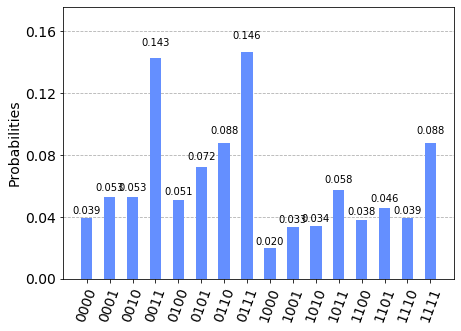

In [48]:
from qiskit.visualization import plot_histogram as hist
bal_counts=bal_job.result().get_counts()
hist(bal_counts)

### The most likely result is 1110. As expected, we didn't get an all-zero state.

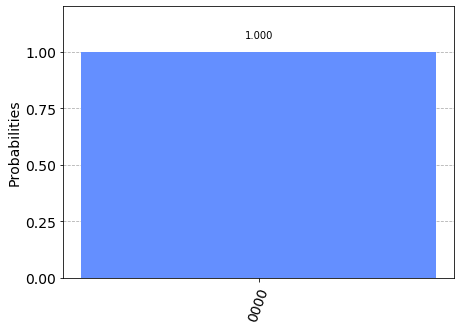

In [49]:
cons_counts=cons_job.result().get_counts()
hist(cons_counts)

### As expected, for a constant oracle, we get an all-zero state 